## News summation
### 뉴스 요약봇 만들기
***
#### Step 1. 데이터 수집하기

    1. 뉴스 기사 데이터 가져오기  

#### Step 2. 데이터 전처리하기 (추상적 요약) 

    -실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 
     추가 사용하여 텍스트를 정규화 또는 정제해 보세요.  
     
    -만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 
     불용어를 제거하는 것이 좋을지 고민해보세요.  

#### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
    일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 
    더 나은 성능을 얻을 수 있어요.  
    
    실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

#### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
    원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.  
    
#### Step 5. Summa을 이용해서 추출적 요약해보기
***
#### 평가문항  
**1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.**  
-분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
  
**2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.**  
-모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
  
**3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.**  
-두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.
***
### Step 1. 데이터 수집하기

In [72]:
# 필요한 라이브러리 import
import os
from os.path import join
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer


**1. 뉴스 기사 데이터 가져오기**

In [4]:
# 노드를 진행하면서 다운받은 뉴스 요약 data 가져오기
# https://github.com/sunnysai12345/News_Summary
data_dir = os.getenv('HOME')+'/aiffel/news_summarization/data'
data_path = join(data_dir, 'news_summary_more.csv')
data = pd.read_csv(data_path, encoding='iso-8859-1')
data.head(5)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


### Step 2. 데이터 전처리하기 (추상적 요약)
    -실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 
     추가 사용하여 텍스트를 정규화 또는 정제해 보세요.  
    -만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 
     불용어를 제거하는 것이 좋을지 고민해보세요.  
***
**1. 중복 샘플 제거**   

중복 샘플을 제거하기전 전체 샘플의 수를 확인해봅니다.

In [8]:
print('전체 샘플수 :',len(data))

전체 샘플수 : 98401


한 칼럼당 98401개의 데이터가 있는것을 확인할 수 있습니다.

In [7]:
for c in data.columns:
    print('{}열의 unique : {}'.format(c, data[c].nunique()))

headlines열의 unique : 98280
text열의 unique : 98360


유니크한 데이터의 갯수를 확인해보니 두개의 칼럼 모두 전체 샘플수와 차이가 나는것을 확인할 수 있습니다.  
이러한 중복 샘플을 제거해 주도록 하겠습니다.

In [9]:
for c in data.columns:
    data.drop_duplicates(subset = [c], inplace = True)

데이터프레임의 drop_duplicates()를 사용하여 중복 샘플을 지워줍니다.

In [10]:
print('전체 샘플수 :',len(data))

전체 샘플수 : 98262


기존의 샘플수와 비교해보았을 때 중복 샘플이 제거 된 것을 확인할 수 있습니다.
***
**2. 결측 샘플 제거**  

Null값을 가지는 데이터 샘플을 확인해봅니다.

In [11]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


.isnull().sum()로 확인해본 결과 다행히 결측치는 없는 것으로 확인되었습니다.  
참고로 Null값 제거에는 dropna() 함수를 사용하면 됩니다.
***   
**3. 텍스트 정규화 및 불용어 제거**  

i'am, it'll 등 줄여진 표현들을 정리하여 연산량을 줄이도록 하겠습니다.

In [12]:
# 노드에서 사용하였던 정규화 사전을 이용하도록 하겠습니다.
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

In [16]:
# 텍스트 소문자화 => 섞여있을 수 있는 ltml태그 제거 => 특수문자 제거 => 정규화 => 불용어 제거
# 위의 과정을 위한 함수 생성
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

이제 함수를 활용하여 text칼럼과 headline칼럼을 정리해주도록 하겠습니다.

In [17]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))
    
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [20]:
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))
    # 요약이므로 불용어를 제외할 경우 문장 자체가 이상해질 수 있음.

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

두 칼럼에서 불용어를 모두 정리를 완료했으니 해당칼럼을 교체해주도록 합니다.

In [21]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 불용어를 제거하면서 빈 값이 생겼을 수도 있으니
# 빈 값을 Null 값으로 변환합니다.
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

다행히 빈 샘플이 없습니다.  
이제 샘플 문장의 최대길이를 설정하겠습니다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
텍스트의 표준 편차 : 3.7996134352887116
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299444342675704
헤드라인의 표준 편차 : 1.3899968497820723


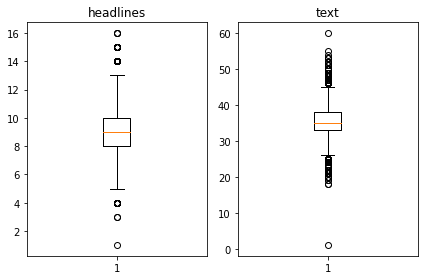

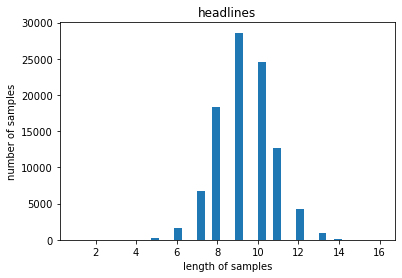

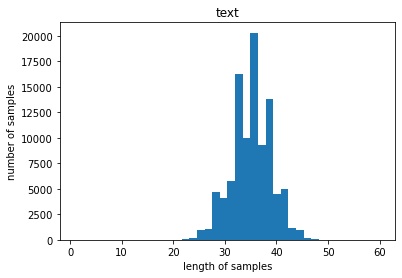

In [23]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 표준 편차 : {}'.format(np.std(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('헤드라인의 표준 편차 : {}'.format(np.std(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

생각보다 데이터가 고르게 분포되어있습니다.  
각 칼럼 샘플의 최대길이는 (평균+(2x표준편차로)) 결정하겠습니다.

In [50]:
text_maxlen = int((np.mean(text_len)+(2*np.std(text_len))))
headlines_maxlen = int((np.mean(headlines_len)+(2*np.std(headlines_len))))

In [52]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_maxlen)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_maxlen)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 94658


In [53]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [54]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [55]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 18931


In [56]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 75727
훈련 레이블의 개수 : 75727
테스트 데이터의 개수 : 18931
테스트 레이블의 개수 : 18931


In [57]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [58]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67864
등장 빈도가 6번 이하인 희귀 단어의 수: 46163
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21701
단어 집합에서 희귀 단어의 비율: 68.02281032653542
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5513729267157848


In [59]:
src_vocab = 21000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [60]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[10965, 7803, 354, 1124, 87, 22, 5945, 7353, 326, 8, 307, 2095, 1124, 10965, 1124, 982, 2234, 20204, 326, 8, 64, 285, 296, 10965, 3393, 296, 548, 1124, 1711, 1102], [73, 38, 13924, 2293, 2612, 9084, 8322, 395, 209, 1837, 7063, 5265, 826, 167, 387, 4767, 139, 488, 209, 68, 7063, 1441, 10966, 841, 62, 209, 68, 999, 594, 2, 10207, 12, 1564], [26, 78, 1185, 873, 63, 1, 413, 2265, 6503, 3377, 662, 140, 1042, 3602, 4, 253, 6577, 233, 25, 26, 1241, 729, 295, 2396, 8, 3377, 662, 55, 3394, 653]]


In [61]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [62]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29597
등장 빈도가 5번 이하인 희귀 단어의 수: 19349
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10248
단어 집합에서 희귀 단어의 비율: 65.37486907456837
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.760733288424805


In [63]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 5740, 1643, 3, 18, 706, 981, 59, 168, 1594], [1, 4040, 160, 10, 1244, 451, 105, 3, 21, 7477, 34, 6030, 464], [1, 1540, 1166, 73, 10, 222, 26, 35, 456], [1, 148, 19, 4, 345, 9, 74, 815, 2812, 12, 1315], [1, 85, 970, 5741, 2326, 13, 397, 1421, 11, 59]]
target
decoder  [[5740, 1643, 3, 18, 706, 981, 59, 168, 1594, 2], [4040, 160, 10, 1244, 451, 105, 3, 21, 7477, 34, 6030, 464, 2], [1540, 1166, 73, 10, 222, 26, 35, 456, 2], [148, 19, 4, 345, 9, 74, 815, 2812, 12, 1315, 2], [85, 970, 5741, 2326, 13, 397, 1421, 11, 59, 2]]


In [64]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75727
훈련 레이블의 개수 : 75727
테스트 데이터의 개수 : 18931
테스트 레이블의 개수 : 18931


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [65]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_maxlen, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_maxlen, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_maxlen, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_maxlen, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_maxlen, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_maxlen, padding='post')

-모델링

In [73]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_maxlen,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)



# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2688000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [74]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_maxlen,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)



# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])


# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model_attn = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model_attn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 42, 128)      2688000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 42, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [75]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
296/296 [==============================] - 90s 304ms/step - loss: 5.7161 - val_loss: 5.3688
Epoch 2/50
296/296 [==============================] - 89s 302ms/step - loss: 5.3005 - val_loss: 5.1219
Epoch 3/50
296/296 [==============================] - 90s 303ms/step - loss: 5.0199 - val_loss: 4.8385
Epoch 4/50
296/296 [==============================] - 90s 304ms/step - loss: 4.7329 - val_loss: 4.6022
Epoch 5/50
296/296 [==============================] - 89s 302ms/step - loss: 4.5268 - val_loss: 4.4486
Epoch 6/50
296/296 [==============================] - 93s 314ms/step - loss: 4.3536 - val_loss: 4.3286
Epoch 7/50
296/296 [==============================] - 90s 303ms/step - loss: 4.2073 - val_loss: 4.2131
Epoch 8/50
296/296 [==============================] - 92s 311ms/step - loss: 4.0819 - val_loss: 4.1251
Epoch 9/50
296/296 [==============================] - 90s 304ms/step - loss: 3.9729 - val_loss: 4.0571
Epoch 10/50
296/296 [==============================] - 96s 325ms/step - l

In [ ]:
model_attn.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.


Step 2. 데이터 전처리하기 (추상적 요약)
1. 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 
   추가 사용하여 텍스트를 정규화 또는 정제해 보세요.  
2. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 
   불용어를 제거하는 것이 좋을지 고민해보세요.  
Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 
더 나은 성능을 얻을 수 있어요. 
실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.
Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.  
Step 5. Summa을 이용해서 추출적 요약해보기
